# Neural Networks

#### Some imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Plotting: 

In [2]:
#This function plots the contourline func(x) = value
def plot_contour_line(func, value=0, x_values=np.empty(0)):
    
    minx = -1
    maxx = 2
    miny = -1
    maxy = 2
    
    #print(np.array(x_values.shape))
    if (np.array(x_values.shape)[1] ==2):
        x_values = x_values.T
    
    # sets minx, etc. if x_values is a two-dimensoinal array of values
    if np.array(x_values.shape).shape[0] > 1:
        dim = np.array(x_values.shape)[0]
        if dim==2:
            minx = ((int)(np.amin(x_values[0])))-1.5
            maxx = ((int)(np.amax(x_values[0])))+1.5
            miny = ((int)(np.amin(x_values[1])))-1.5
            maxy = ((int)(np.amax(x_values[1])))+1.5
    samplenum = 100
    xrange = np.arange(minx, maxx, (maxx-minx)/samplenum)
    yrange = np.arange(miny, maxy, (maxy-miny)/samplenum)
    
    #This generates a two-dimensional mesh
    X, Y = np.meshgrid(xrange,yrange)
    # print(X,Y)
    
    argsForf = np.array([X.flatten(),Y.flatten()]).T
    Z = func(argsForf)
    Z = np.reshape(Z,X.shape)
    
    plt.xlim(minx, maxx)
    plt.ylim(miny, maxy)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.contour(X, Y, Z, alpha=0.5,levels=[value],linestyles='dashed',linewidths=3)
    Z = np.where(Z > value, 1, -1)
    plt.contourf(X, Y, Z, alpha=0.2, cmap=plt.cm.coolwarm)


Some code illustrating the numpy linear algebra operations I'm using:

In [3]:
A = np.array([[1,2,3],[4,5,6],[7,8,9]])
b = np.array([[1,2,3],[1,2,3],[1,2,3],[1,2,3],[1,2,3],[1,2,3]])
c1 = np.array([[1,2,3],[1,2,3]])
c2 = np.array([[1,1,1],[3,3,3]])
M = np.array([[[1,2,3],[4,5,6],[7,8,9]], [[1,2,3],[4,5,6],[7,8,9]], [[1,2,3],[4,5,6],[7,8,9]], [[1,2,3],[4,5,6],[7,8,9]]])

print(A@b[0])
print("tensordot:")
print(np.tensordot(A, b, axes=[1,1]).T)
print("einsum:")
print(np.einsum('ij,ik->ijk',c1,c2))
print("sum:")
print(np.sum(M, axis=0))


[14 32 50]
tensordot:
[[14 32 50]
 [14 32 50]
 [14 32 50]
 [14 32 50]
 [14 32 50]
 [14 32 50]]
einsum:
[[[1 1 1]
  [2 2 2]
  [3 3 3]]

 [[3 3 3]
  [6 6 6]
  [9 9 9]]]
sum:
[[ 4  8 12]
 [16 20 24]
 [28 32 36]]


#### Some activation functions and their derivatives:

In [4]:
# rectified linear unit: this seems to be the fastest implementation using numpy's clip method
def ReLU(x): return np.clip(x,0,None)

# the (weak) derivative of ReLU, again using numpy
def Heaviside(x): return np.heaviside(x,0)

# unnecessary function call, for the sake of compactness/readability
def Id(x): return x

# makes vectorization possible, again using numpy's clip method
def One(x): return np.clip(x,1,1)

### A (multy-layer, feed-forward) neural network class:

In [7]:
class NN:
    
    # Initialize neural network of depth L=2: each layer i=0..L consists
    # of d[i] nodes ......
    def __init__(self, d, L=2, phi=[ReLU,Id], dphi=[Heaviside,One]):
        # check wether L, d, phi, Dphi are all compatible
        assert len(d) == L+1, "len(d) != L+1"
        assert len(phi) == L, "len(phi) != L"
        assert len(dphi) == L, "len(dphi) != L"
        # set parameters
        self.d   = d
        self.L   = L
        self.phi = phi
        self.dphi = dphi
        # initialize weights
        self.W = [np.random.uniform(-1, 1, (d[l],d[l+1])) for l in range(L)]
        # initialize biases
        self.b = [np.random.uniform(-1, 1, d[l+1]) for l in range(L)]
    
    
    # forward propagation 1: evaluates NN at array of points x  
    def f(self, x):
        # initialize with the input layer
        net = x
        # the actual forward propagation using np.tensordot
        for l in range(self.L):
            net = np.tensordot(self.W[l].T, self.phi[l](net), axes=[1,1]).T + self.b[l]
        return net
    
    
    # forward propagation 2: calculates all net sums 
    def ffwd(self, x):
        # initialize: there will be L net sums in total, plus net[0]=x
        net = [x]*(self.L+1)
        net_ = x
        # the actual forward propagation using np.tensordot
        for l in range(self.L):
            net_ = np.tensordot(self.W[l].T, self.phi[l](net_), axes=[1,1]).T + self.b[l]
            net[l+1] = net_
        return net
    
    
    # back propagation: computes gradient of the least squares loss
    # C(f)=1/n*sum((f(x)-y)**2) with respect to W and b.
    def bprop(self, x, y): 
        # check wether x and y have compatible shapes
        assert x.shape[0] == y.shape[0], "x.shape[0] != y.shape[0]"
        # size of the batch
        n = x.shape[0]
        # initialize variables
        delta, dphi_net = 0, 0
        gradW, gradb = [None]*self.L, [None]*self.L
        net = self.ffwd(x)
        # the actual backpropagation 
        for l in range(self.L-1,-1,-1):
            
            #print("backpropagation: l =",l,":")
            #print("shape of y:", y.shape)
            #print("shape of f(x):", self.f(x).shape)
            
            if l == self.L-1: delta = 2*(self.f(x)-y)
            else: delta = np.tensordot(self.W[l+1], gradb[l+1], axes=[1,1]).T  
                
            #print("shape of delta:", delta.shape)
            
            dphi_net = self.dphi[l](net[l+1])
            
            #print("shape of dphinet:", dphi_net.shape)
            #print("shape of self.phi[l](net[l+1]):", self.phi[l](net[l+1]).shape)
            
            gradb[l] = delta*dphi_net
            
            # using einsum to calculate element-wise dyadic product
            gradW[l] = np.einsum('ij,ik->ijk', self.phi[l](net[l]), gradb[l]) 
            
            #print("shape of gradW:", gradW[l].shape, "\nshape of gradb:", gradb[l].shape)
            #print("shape of W:", self.W[l].shape, "\nshape of b:", self.b[l].shape)
            
        # sum and average the results
        for l in range(self.L):
            
            #print("summation and average: l =",l,":")
            
            gradW[l] = np.sum(gradW[l], axis=0)/n 
            gradb[l] = np.sum(gradb[l], axis=0)/n
            
            #print("shape of gradW:", gradW[l].shape)
            #print("shape of gradb:", gradb[l].shape)
            
        return gradW, gradb
    
    
    # Stochastic minibatch gradient descent: minimizes least squares loss.
    # D is the data set, 'nu' is the learning rate, K the size of the minibatch,
    # and S is the number of steps.
    def SGD(self, x, y, nu, K=10, S=500, output=False):
        for s in range(S):
            
            #print("s =",s)

            n = x.shape[0]
            B = np.random.choice(n, K, replace=False)
            gradW, gradb = self.bprop(x[B,], y[B,])
            
            for l in range(self.L):
                
                #print("SGD: l =",l)
                #print("gradW[",l,"]:")
                #print(gradW[l].shape)
                #print("W[",l,"]:")
                #print(self.W[l].shape)
                #print("gradb[",l,"]:")
                #print(gradb[l].shape)
                #print("b[",l,"]:")
                #print(self.b[l].shape)
                
                self.W[l] = self.W[l]-nu*gradW[l]
                self.b[l] = self.b[l]-nu*gradb[l]
            if output == True and not s%int(S/10):
                print("s =",s)
                print("squares error:", np.sum((self.f(x)-y)**2))
                print("norm of gradient (W):", np.sum(gradW[0]**2),np.sum(gradW[1]**2))
                print("norm of gradient (b):", np.sum(gradb[0]**2),np.sum(gradb[1]**2))
    

#### Generate random data to test the NN class:

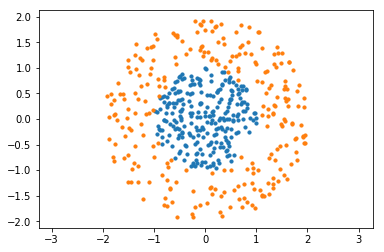

In [8]:
N = 250 # half of number of data points

# test data: uniform distribution on the unit circle
x1 = np.sqrt(np.random.rand(N))*np.exp(np.random.rand(N)*2j*np.pi)

# convert complex to 2d array 
x1 = np.stack((x1.real,x1.imag),-1)

# the same for 1≤|x|≤2
x2 = np.sqrt(np.random.uniform(1,4,N))*np.exp(np.random.rand(N)*2j*np.pi)
x2 = np.stack((x2.real,x2.imag),-1)

# put the two together
x = np.concatenate((x1,x2))

# the first 250 data points labeled -1, the second half is labeled 1
y = np.concatenate((np.full(N,-1),np.full(N,1)))

# plot the data to see if it has the right distribiution
x1plot = x[y<0].swapaxes(0,1)
x2plot = x[y>0].swapaxes(0,1)
fig, ax = plt.subplots()
ax.scatter(x1plot[0], x1plot[1], s=10)
ax.scatter(x2plot[0], x2plot[1], s=10)
ax.axis('equal')
plt.show()

#### Now we create a two layer NN  with a hidden layer of 20 neurons:
- The input values are from $\mathbb{R}^2$ so there must be 2 input neurons.
- The there are only two output classes, so there is only one neuron in the output layer. 

In [19]:
perceptron = NN([2,20,1])

s = 0
squares error: 383.8854152515322
norm of gradient (W): 0.01588616927249591 0.0006459428105985824
norm of gradient (b): 0.002546704738516167 5.5402124496601067e-05
s = 100
squares error: 383.8850359295193
norm of gradient (W): 0.01577858551110346 0.0006208103567037981
norm of gradient (b): 0.0024814421449700585 5.025599579343047e-05
s = 200
squares error: 383.8833096857735
norm of gradient (W): 0.01483699561384665 0.0005236687458116944
norm of gradient (b): 0.0020795168100243245 3.677045800629942e-05
s = 300
squares error: 383.88195351944324
norm of gradient (W): 0.014492376886853463 0.00043518733734251137
norm of gradient (b): 0.002026595833541053 2.4102208772933278e-05
s = 400
squares error: 383.88191363784466
norm of gradient (W): 0.014552937613129266 0.0004128092226913827
norm of gradient (b): 0.0020587799343279945 1.914530398646203e-05
s = 500
squares error: 383.88206045985214
norm of gradient (W): 0.014584247570883918 0.00040457301774860996
norm of gradient (b): 0.0017341037

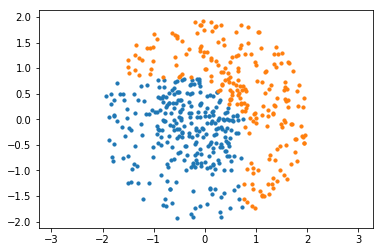

s = 0
squares error: 383.8829168432566
norm of gradient (W): 0.014913782399833271 0.00045399044806740103
norm of gradient (b): 0.0020184274305046837 2.2285435537984602e-05
s = 100
squares error: 383.88290812248084
norm of gradient (W): 0.01491370840588124 0.00045433676893605286
norm of gradient (b): 0.00201882587153584 2.244853697011129e-05
s = 200
squares error: 383.8828886556623
norm of gradient (W): 0.01487032070351196 0.00045406410841083766
norm of gradient (b): 0.00198171106354085 2.2544098200770476e-05
s = 300
squares error: 383.8828648822107
norm of gradient (W): 0.01487128370858492 0.00045352047220262353
norm of gradient (b): 0.0019821020493069543 2.260235375558557e-05
s = 400
squares error: 383.88285971657297
norm of gradient (W): 0.014924155347223775 0.00045395462333746965
norm of gradient (b): 0.0020453470815057708 2.2753637677332017e-05
s = 500
squares error: 383.8828384554036
norm of gradient (W): 0.014891194191362941 0.0004534703914153097
norm of gradient (b): 0.001919858

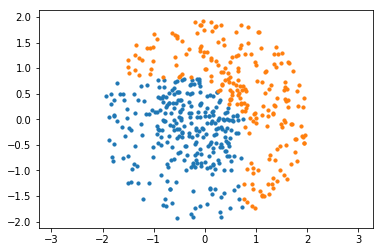

In [18]:
for nu in [0.001,0.0001]:
    perceptron.SGD(x, y.reshape(500,1), nu, K=500, S=1000, output=True)
    
    c = perceptron.f(x).reshape(500)
    c1plot = x[c<0].swapaxes(0,1)
    c2plot = x[c>0].swapaxes(0,1)
    fig, ax = plt.subplots()
    ax.scatter(c1plot[0], c1plot[1], s=10)
    ax.scatter(c2plot[0], c2plot[1], s=10)
    ax.axis('equal')
    plt.show()

In [11]:
# test bprop directly
perceptron.bprop(x,y.reshape(500,1))

([array([[-7.85714533e-03, -9.71518922e-03,  1.46293749e-02,
           0.00000000e+00,  0.00000000e+00,  2.37377223e-02,
          -2.84250187e-03,  2.18905550e-04,  3.70193732e-04,
          -9.50151668e-02,  1.87082041e-02,  2.18310610e-03,
          -4.35326984e-03,  1.05249255e-02,  0.00000000e+00,
          -5.36729772e-05,  0.00000000e+00, -3.21706583e-02,
           0.00000000e+00,  7.96173829e-03],
         [ 2.36373726e-02,  2.67785464e-03, -4.72742089e-03,
           0.00000000e+00,  0.00000000e+00, -1.85234886e-03,
           8.54791629e-05, -6.25293140e-06,  7.15362046e-04,
          -1.86076018e-03, -9.80186198e-02,  2.72807921e-03,
           3.44829504e-04, -2.90104700e-03,  0.00000000e+00,
           1.66456253e-04,  0.00000000e+00,  3.93705839e-02,
           0.00000000e+00,  1.23491645e-02]]), array([[ 0.0151428 ],
         [ 0.01163244],
         [ 0.01100093],
         [-0.01884288],
         [-0.01550775],
         [ 0.00834179],
         [ 0.00181515],
         [

In [12]:
test = NN([1,1,1])
triv = np.array([[1]])
print(test.W)
print(test.b)

[array([[-0.92228714]]), array([[-0.82700613]])]
[array([0.75917272]), array([0.93522312])]


In [13]:
test.f(triv)

array([[1.07011974]])

In [14]:
test.SGD(triv,triv,K=1,S=100,nu=.1,output=True)
test.f(triv)

s = 0
squares error: 0.0031050153617642583
norm of gradient (W): 0.0 0.0005232692675314251
norm of gradient (b): 0.0 0.01966711050322313
s = 10
squares error: 3.132532737235466e-05
norm of gradient (W): 0.0 5.2790660269070946e-06
norm of gradient (b): 0.0 0.00019841405056099102
s = 20
squares error: 3.1602939781516597e-07
norm of gradient (W): 0.0 5.3258503500355654e-08
norm of gradient (b): 0.0 2.001724424824713e-06
s = 30
squares error: 3.1883012457064225e-09
norm of gradient (W): 0.0 5.373049286813813e-10
norm of gradient (b): 0.0 2.019464176857765e-08
s = 40
squares error: 3.216556720157245e-11
norm of gradient (W): 0.0 5.420666511496338e-12
norm of gradient (b): 0.0 2.0373611426800846e-10
s = 50
squares error: 3.245062602660061e-13
norm of gradient (W): 0.0 5.468705731684826e-14
norm of gradient (b): 0.0 2.0554167157962516e-12
s = 60
squares error: 3.2738210973609473e-15
norm of gradient (W): 0.0 5.517170661364649e-16
norm of gradient (b): 0.0 2.0736322921101573e-14
s = 70
squares

array([[1.]])

In [15]:
test2 = NN([4,1],L=1,phi=[Id],dphi=[One])
triv2 = np.array([[1,2,3,4]])
print(test2.W)
print(test2.b)
print(test2.f(triv2))
print(np.dot(test2.W[0].flatten(),triv2.flatten())+test2.b[0])

[array([[ 0.74292854],
       [-0.72558837],
       [-0.27792435],
       [ 0.98660469]])]
[array([0.76934754])]
[[3.17374508]]
[3.17374508]
